# Question 1 Train a AutoEncoder + CLF on CIFAR-10 with specified params

## Checking Avilable GPU

In [1]:
!nvidia-smi

Mon Feb 13 03:45:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   46C    P8    35W / 350W |    182MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
    import torchmetrics
except:
    !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch

### Downloading Dataset

In [4]:
from torchvision import transforms

# for simple conversion to grayscale and then to tensor
image_train_trasform_simple = transforms.Compose(
        [
                # transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()
        ]
)

# for simple conversion to grayscale + augmentation and then to tensor
image_train_trasform_augmented = transforms.Compose(
        [
                # transforms.Grayscale(num_output_channels=1),
                transforms.RandomRotation(10), # as mentioned in the question paper
                transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 0.2)), # as mentioned in the question paper
                transforms.ToTensor()
        ]
)

image_test_trasform = transforms.Compose(
        [
                # transforms.Grayscale(num_output_channels=1),
                # no need to apply in test dataset
                transforms.ToTensor()
        ]
)

# plain dataset
train_dataset_original = torchvision.datasets.CIFAR10(
        root = 'data/',
        download = True,
        train = True,
        transform = image_train_trasform_simple
)

# augmented dataset
train_dataset_augmented = torchvision.datasets.CIFAR10(
        root = 'data/',
        download = True,
        train = True,
        transform = image_train_trasform_augmented
)

train_dataset_all_classes = torch.utils.data.ConcatDataset([train_dataset_original, train_dataset_augmented])

# removing non-required classes
final_subset = []
for idx,data in enumerate(train_dataset_all_classes):
  if data[1] in [0,2,4,6,8]: # specific classes, mentioned in the paper.
    final_subset.append(idx)

train_dataset = torch.utils.data.Subset(train_dataset_all_classes,final_subset)

test_dataset_all_classes = torchvision.datasets.CIFAR10(
        root = 'data/',
        download = True,
        train = False,
        transform = image_test_trasform
)

# removing non-required classes
final_subset = []
for idx,data in enumerate(test_dataset_all_classes):
  if data[1] in [0,2,4,6,8]: # specific classes, mentioned in the paper.
    final_subset.append(idx)

test_dataset = torch.utils.data.Subset(test_dataset_all_classes,final_subset)

# train_dataset_original, train_dataset_augmented ,test_dataset
train_dataset, test_dataset

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(<torch.utils.data.dataset.Subset at 0x7f87bb2b7f40>,
 <torch.utils.data.dataset.Subset at 0x7f87bb2b7310>)

In [5]:
print("len of train dataset all class",len(train_dataset_all_classes),"5 class",len(train_dataset))
print("len of test dataset",len(test_dataset_all_classes),"5 class",len(test_dataset))

len of train dataset all class 100000 5 class 50000
len of test dataset 10000 5 class 5000


### Vis. dataset (train dataset)

In [6]:
# randomly ploting image samples from the grayscale dataset
def visualization(dataset):
  labels_map = dataset.class_to_idx # getting class -> index map
  labels_map = dict(map(reversed, labels_map.items())) # inverting dict
  # print(labels_map)

  figure = plt.figure(figsize=(12, 12)) # fixing plotsize
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)) # randomely selecting one image sample from the image index
      img, label = dataset[sample_idx] # getting image and label of selected index
      # sub plot code
      figure.add_subplot(rows, cols, i) 
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1,2,0)) # NOTE:- Color map is gray because we're converting imgae to grayscale / permuting for color channel
      # sub plot code ends
  plt.show()

			 SAMPELS FORM Original Dataset


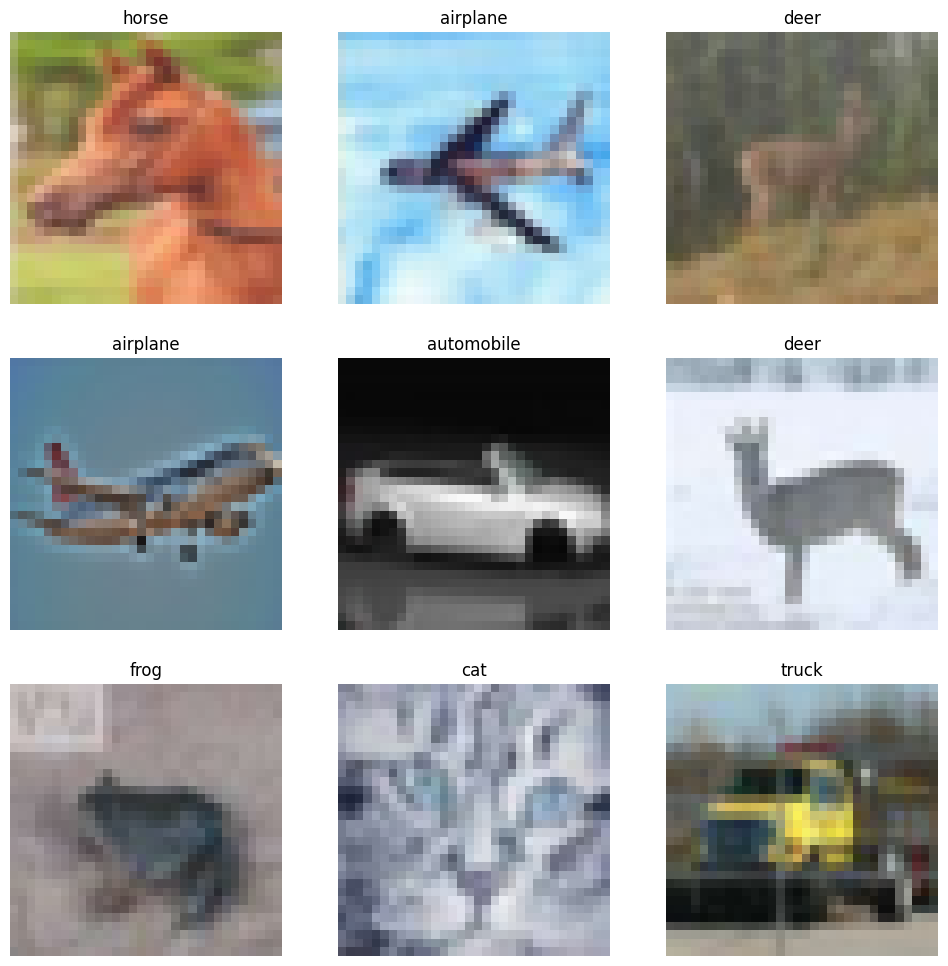


			 SAMPELS FORM Augmented Dataset


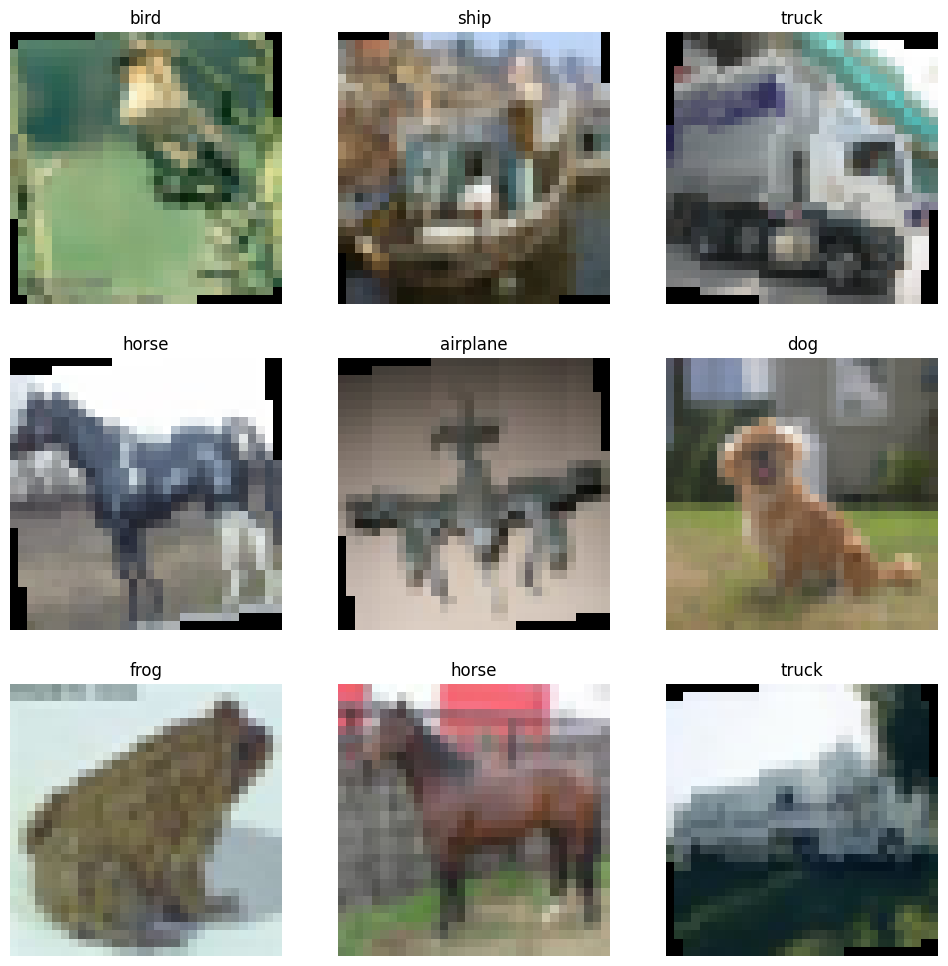

In [7]:
print("\t\t\t SAMPELS FORM Original Dataset")
visualization(train_dataset_original)
print()
print("\t\t\t SAMPELS FORM Augmented Dataset")
visualization(train_dataset_augmented)

### Converting dataset to dataloader

In [8]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # no. of avilable cpu cores

# train dataloaders
train_dataloader = torch.utils.data.DataLoader(
        dataset = train_dataset,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS     
)

# train_dataloader_original = torch.utils.data.DataLoader(
#         dataset = train_dataset_original,
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers = NUM_WORKERS     
# )

# train_dataloader_augmented = torch.utils.data.DataLoader(
#         dataset = train_dataset_augmented,
#         batch_size = BATCH_SIZE,
#         shuffle = True,
#         num_workers = NUM_WORKERS     
# )

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
        dataset = test_dataset,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = NUM_WORKERS     
)

print(f"Numbers of Batches in Train Dataloader Original: {len(train_dataloader)}")
# print(f"Numbers of Batches in Train Dataloader Augmented: {len(train_dataloader_augmented)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader Original: 782
Numbers of Batches in Test Dataloader: 79


## Defining Model

In [9]:
class AE(nn.Module):
  f = nn.Flatten()
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      activation_function:nn.Module,
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      activation_function: activation function to be used in the neural net.
    '''
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_channels, hidden_units), # layer input
        activation_function,
        )
    self.decoder = nn.Sequential(
        nn.Linear(hidden_units, hidden_units), # layer hidden
        activation_function,
        nn.Linear(hidden_units, in_channels), # layer output
        )
    nn.init.xavier_uniform_(self.encoder[1].weight)
    nn.init.xavier_uniform_(self.decoder[0].weight)
    nn.init.xavier_uniform_(self.decoder[2].weight)


  def encode(self, x):
      return self.encoder(x)

  def decode(self, z):
      return self.decoder(z)

  def forward(self, x):
    # print(x.shape)
    x = self.encode(x)
    # print(x.shape)
    x = self.decode(x)
    # print(x.shape)
    return x

## Train Test Fucntions

### training step

In [10]:
height = next(iter(train_dataloader))[0].shape[2]
width = next(iter(train_dataloader))[0].shape[2]
color_channels = next(iter(train_dataloader))[0].shape[1]
height,width,color_channels

(32, 32, 3)

In [11]:
def train_step_ae(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device
               ):
  train_loss =  0
  model.train()
  for (X,y) in data_loader:
    # Send data to GPU
    X, y = X.to(device), y.to(device)
    
    # 1. Forward pass
    y_pred = model(X.view(-1,height*width*color_channels))

    # 2. Calculate loss
    loss = loss_fn(y_pred.view(-1,height*width*color_channels), X.view(-1,height*width*color_channels))
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | ",end="")
  return train_loss.item()

def test_step_ae(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss = 0
  model.eval() # put model in eval mode
  # Turn on inference context manager
  with torch.inference_mode(): 
      for (X, y) in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        test_pred = model(X.view(-1,height*width*color_channels))
        
        # 2. Calculate loss and accuracy
        test_loss += loss_fn(test_pred, X.view(-1,height*width*color_channels))
      
      # Adjust metrics and print out
      test_loss /= len(data_loader)
      print(f"Test loss: {test_loss:.5f}")
  return test_loss.item()

### traing loop

In [12]:
from tqdm.auto import tqdm

def train_ae(model:nn.Module,epochs:int,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,train_dataloader:torch.utils.data.DataLoader,test_dataloader:torch.utils.data.DataLoader,device:torch.device):
  result_dict = {"train_loss":[],"test_loss":[]}
  for epoch in tqdm(range(epochs)):
    print(f"EPOCH: {epoch} | ",end="")
    result_dict["train_loss"].append( train_step_ae(model,train_dataloader,loss_fn,optimizer,device) )
    result_dict["test_loss"].append( test_step_ae(model,test_dataloader,loss_fn,device) )
  return result_dict

## Plot loss and acc. curves funtion

In [13]:
from typing import Dict,List

def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Desc:
      Plots training curves of a results dictionary.

    Args:
      results (dict): dictionary containing list of values, e.g.
          {"train_loss": [...],
            "train_acc": [...],
            "test_loss": [...],
            "test_acc": [...]}
    """
    acc_flag = True

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    try:
      accuracy = results['train_acc']
      test_accuracy = results['test_acc']
    except:
      acc_flag = False
    

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    if acc_flag:
      plt.subplot(1, 2, 2)
      plt.plot(epochs, accuracy, label='train_accuracy')
      plt.plot(epochs, test_accuracy, label='test_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()
      plt.show()

## Model Defination and training Auto Encoder

In [14]:
class_names = test_dataloader.dataset.dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [15]:
model_ae = AE(
    in_channels = 32*32*3,
    hidden_units = 1024,
    activation_function = nn.ReLU()
).to(device)

model_ae

AE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3072, bias=True)
  )
)

In [16]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip -q install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_ae, input_size=[32, 3, 32, 32]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [32, 3072]                --
├─Sequential: 1-1                        [32, 1024]                --
│    └─Flatten: 2-1                      [32, 3072]                --
│    └─Linear: 2-2                       [32, 1024]                3,146,752
├─Sequential: 1-2                        --                        (recursive)
│    └─ReLU: 2-3                         [32, 1024]                --
├─Sequential: 1-3                        [32, 3072]                --
│    └─Linear: 2-4                       [32, 1024]                1,049,600
│    └─ReLU: 2-5                         [32, 1024]                --
│    └─Linear: 2-6                       [32, 3072]                3,148,800
Total params: 7,345,152
Trainable params: 7,345,152
Non-trainable params: 0
Total mult-adds (M): 235.04
Input size (MB): 0.39
Forward/backward pass size (MB): 1.31
Params size (MB): 29.38
Estimat

In [17]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.MSELoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_ae.parameters(), lr=1e-3)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_ae_results = train_ae(model=model_ae, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")
# print(model_ae_results)

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH: 0 | Train loss: 0.01622 | Test loss: 0.00938
EPOCH: 1 | Train loss: 0.00855 | Test loss: 0.00728
EPOCH: 2 | Train loss: 0.00727 | Test loss: 0.00631
EPOCH: 3 | Train loss: 0.00673 | Test loss: 0.00588
EPOCH: 4 | Train loss: 0.00624 | Test loss: 0.00678
EPOCH: 5 | Train loss: 0.00612 | Test loss: 0.00571
EPOCH: 6 | Train loss: 0.00607 | Test loss: 0.00538
EPOCH: 7 | Train loss: 0.00589 | Test loss: 0.00561
EPOCH: 8 | Train loss: 0.00592 | Test loss: 0.00589
EPOCH: 9 | Train loss: 0.00589 | Test loss: 0.00567
EPOCH: 10 | Train loss: 0.00591 | Test loss: 0.00575
EPOCH: 11 | Train loss: 0.00581 | Test loss: 0.00542
EPOCH: 12 | Train loss: 0.00584 | Test loss: 0.00539
EPOCH: 13 | Train loss: 0.00577 | Test loss: 0.00535
EPOCH: 14 | Train loss: 0.00577 | Test loss: 0.00550
EPOCH: 15 | Train loss: 0.00575 | Test loss: 0.00580
EPOCH: 16 | Train loss: 0.00572 | Test loss: 0.00555
EPOCH: 17 | Train loss: 0.00568 | Test loss: 0.00556
EPOCH: 18 | Train loss: 0.00566 | Test loss: 0.00525
EPO

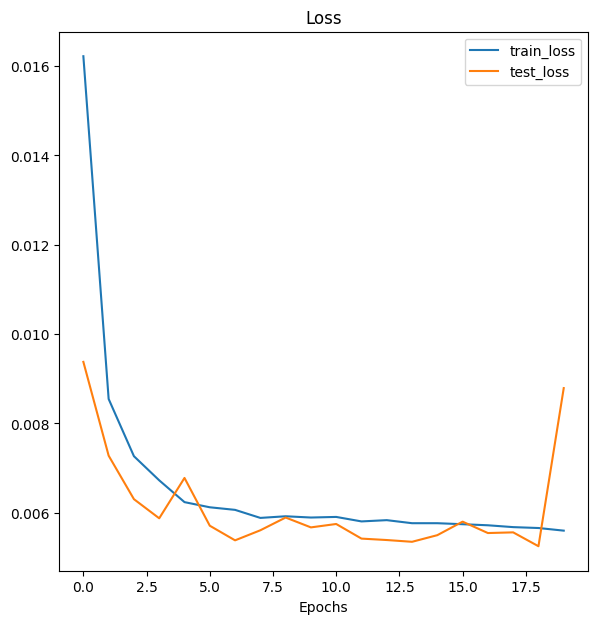

In [18]:
plot_loss_curves(model_ae_results)

## Defining the CLF. model

In [19]:
class Clf1FC(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the data
    '''
    super().__init__()
    self.ae = model_ae
    self.clf = nn.Sequential(
        nn.Linear(in_channels, hidden_units), # FC layer 1
        nn.Sigmoid(),
        nn.Linear(hidden_units, out_channels), # output layer 1
        )
    
  def forward(self, x):
    # print(x.shape)
    x = self.ae.encode(x)
    # print(x.shape)
    x = self.clf(x)
    # print(x.shape)
    return x

### Traing clf with autoencoder

In [20]:
model_fc1_ac = Clf1FC(
    in_channels = 1024, # must be same as Encoder Output
    hidden_units = 512, # number of nodes in FC layer
    out_channels = len(class_names)
    ).to(device)

model_fc1_ac

Clf1FC(
  (ae): AE(
    (encoder): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=3072, out_features=1024, bias=True)
      (2): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=3072, bias=True)
    )
  )
  (clf): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [21]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str
    ):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train() # putting model in traing model

    train_loss, train_acc = 0, 0 # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X,y) in dataloader: # loop in batches
      # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
      X,y = X.to(device), y.to(device) # sending the data to target device
      # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

      # 1. forward pass
      y_pred_logits = model(X.view(-1,height*width*color_channels))

      # 2. calculate the loss
      loss = loss_fn(y_pred_logits, y)
      train_loss += loss.item()

      # 3. optimizer zero grad
      optimizer.zero_grad()

      # 4. loss backword
      loss.backward()

      # 5. optimizer step
      optimizer.step()

      train_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.x
    return train_loss/len(dataloader), train_acc/len(dataloader)


def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str
    ):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval() # putting model in eval model

    test_loss, test_acc = 0, 0 # initlizing loss and acc. for the epoch

    with torch.inference_mode():
      for (X,y) in dataloader: # loop in batches
        X,y = X.to(device), y.to(device) # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X.view(-1,height*width*color_channels))

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits.argmax(dim = 1), y).item()

    # 6. returning actual loss and acc.
    return test_loss/len(dataloader), test_acc/len(dataloader)


from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    epochs: int,
    regularizer = None,
    dropout = None,
  ):
  """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      regularizer (function) = None: A penalty function
      dropout (function) = None: A dropout function takes input -> random_drop_neuron(model: nn.Module,seed:int = 42)
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
  """
  # 1. init. result dict
  result_dict = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  
  # 2. loop in range epochs performs train and test steps on the model
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            acc_fn=acc_fn,
                                            optimizer=optimizer,
                                            device=device
                                          )

    test_loss, test_acc = testing_step(
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        device=device
                                      )
  
  # 3. print out results
    print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
    
  # 4. adding results to result_dict
    result_dict["train_loss"].append(train_loss)
    result_dict["train_acc"].append(train_acc)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_acc"].append(test_acc)

  # 5. return result dict
  return result_dict

In [22]:
# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device=device)
optimizer = torch.optim.Adam(params=model_fc1_ac.parameters(), lr=1e-3)

# importing and init. the timer for checking model training time
from timeit import default_timer as timer
start_time = timer()

# train model
model_fc1_ac_result = train(model=model_fc1_ac, 
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      device=device,
      loss_fn=loss_fn, 
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
# print("model stats:")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2065 | train_acc: 0.2425 | test_loss: 1.0958 | test_acc: 0.2755
Epoch: 2 | train_loss: 1.0740 | train_acc: 0.2784 | test_loss: 1.0396 | test_acc: 0.2842
Epoch: 3 | train_loss: 1.0200 | train_acc: 0.2916 | test_loss: 0.9715 | test_acc: 0.3023
Epoch: 4 | train_loss: 0.9755 | train_acc: 0.3018 | test_loss: 0.9976 | test_acc: 0.2990
Epoch: 5 | train_loss: 0.9375 | train_acc: 0.3099 | test_loss: 0.9103 | test_acc: 0.3172
Epoch: 6 | train_loss: 0.9115 | train_acc: 0.3169 | test_loss: 0.9212 | test_acc: 0.3145
Epoch: 7 | train_loss: 0.8819 | train_acc: 0.3235 | test_loss: 0.8581 | test_acc: 0.3274
Epoch: 8 | train_loss: 0.8594 | train_acc: 0.3275 | test_loss: 0.8478 | test_acc: 0.3288
Epoch: 9 | train_loss: 0.8266 | train_acc: 0.3343 | test_loss: 0.8462 | test_acc: 0.3305
Epoch: 10 | train_loss: 0.8036 | train_acc: 0.3391 | test_loss: 0.8348 | test_acc: 0.3311
Epoch: 11 | train_loss: 0.7791 | train_acc: 0.3444 | test_loss: 0.7626 | test_acc: 0.3497
Epoch: 12 | train_l

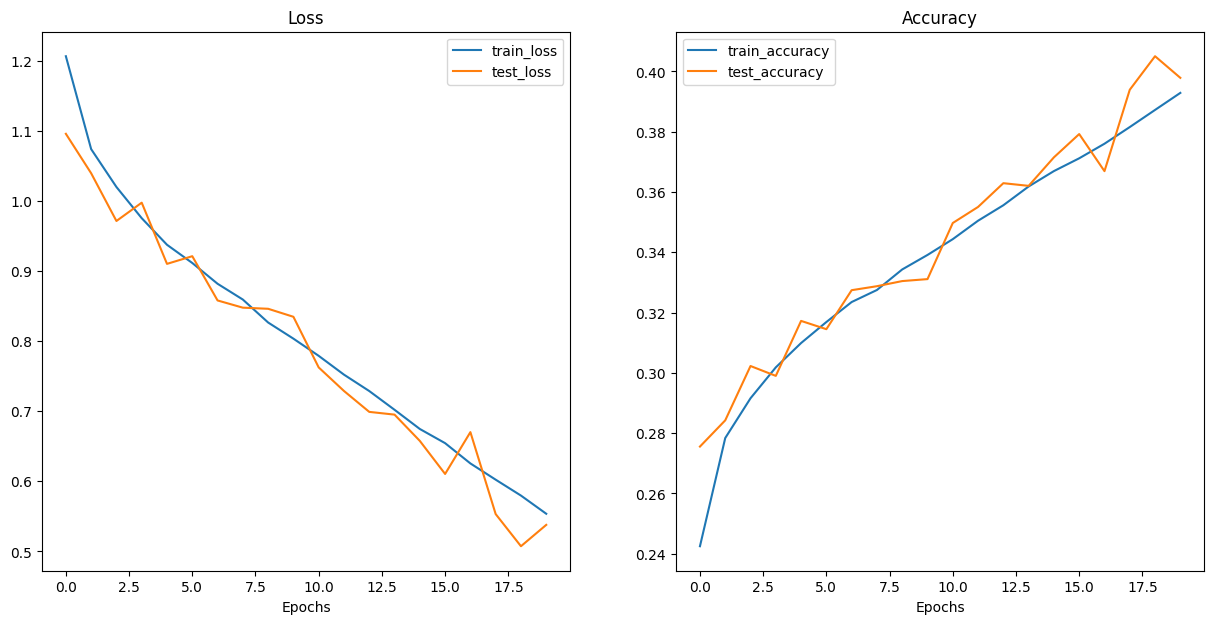

In [23]:
plot_loss_curves(model_fc1_ac_result)